## Author: Graham Hay


## Credit Default Classification

In this notebook, we analyse a data set containing bank loan records, labelled as either a good loan that was repaid or a bad loan where the customer defaulted. The data set was obtained from the Open ML web site at https://www.openml.org/d/31, but originally came from the UCI repository (Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science).

The data set contains 1000 labelled examples with 20 features, of which 700 are good loans and 300 are bad loans. So the data set is imbalanced but not extremely so. It is conventional to assign the minority class to be the positive class (bad loans).

The task is to learn a binary classifier that will predict if a loan to an applicant will be good or bad. To make this task well defined, we will set a target metric that the classifier should achieve.

First, the bank would prefer to avoid making bad loans, so the priority is to identify a high proportion of the positive class (bad loans). Therefore, we set a target of a recall metric of at least 80%.

Second, the data set comes with a cost matrix that specifies the cost of mis-classifying a loan:
"It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1)."
We will use these to obtain a classifier that minimises the cost.

The fundamentals of cost sensitive learning are described in the following paper:
Elkan, C.: 2001, ‘The Foundations of Cost-Sensitive Learning’. In: Proceedings of the IJCAI-01. pp. 973–978.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, plot_roc_curve

from PreProcessing import preprocess_data

TARGET_RECALL = 0.8
CALIBRATION_BINS = 10


In [2]:
# inline only needed in older versions of Jupyter
%matplotlib inline
# Increase the size of the plots from the default (72)
plt.rcParams['figure.dpi'] = 100

### Pre-processing

The data set is loaded and encoded using Pandas and Scikit-Learn.
Ordered categorical features are ordinal encoded and nominal features are one-hot encoded.
Since classifiers based on decision trees does not require the numeric features to be scaled, no scaling is applied.
This means that the classifier is less susceptible to outliers.

In [3]:
    # Load and pre process the Credit data
    x, y, features, classes = preprocess_data()

    # Train / Test split stratified by good or bad loan label
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=42)


dataset_31_credit-g.csv
Input data shape: (1000, 21)


### Class imbalance

There are two main techniques for handling class imbalance: under sampling and over sampling.

Under sampling balances the classes by randomly removing examples of the majority class. This can work well if the majority class has a lot of redundancy.

Over sampling balances the classes by randomly repeating examples of the minority class. This generally works well but increases the size of the data set without adding any additional information.

Here. the class imbalance is handled by using the class_weight='balanced' parameter which is equivalent to over sampling but without increasing the size of the data set.

Another form of over sampling that is available, but not used here, is Synthetic Minority Oversampling Technique (SMOTE) in which additional examples of the minority class are synthesised by interpolating features of similar minority class examples. 

### Initial Random Forest classifier

An initial random forest classifier is trained and applied to the hold-out test set. The confusion matrix is displayed for both training and test data.

Random forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Training confusion matrix
[[490   0]
 [  0 210]]
              precision    recall  f1-score   support

        good       1.00      1.00      1.00       490
         bad       1.00      1.00      1.00       210

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

Test confusion matrix
[[200  10]
 [ 57  33]]
              precision    recall  f1-score   support

        good       0.78      0.95      0.86       210
         bad       0.77     

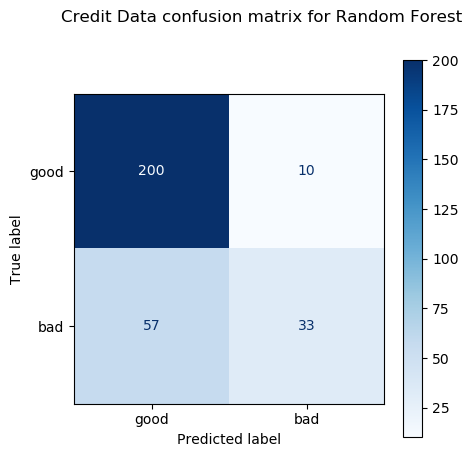

In [4]:
    # Random Forest
    random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=200)
    print('Random forest:', random_forest.get_params())
    random_forest.fit(x_train, y_train)
    y_train_pred = random_forest.predict(x_train)
    cm_train = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    print('Training confusion matrix')
    print(cm_train)
    cr_train = classification_report(y_train, y_train_pred, labels=range(len(classes)), target_names=classes)
    print(cr_train)

    y_test_pred = random_forest.predict(x_test)
    cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    print('Test confusion matrix')
    print(cm_test)
    cr_test = classification_report(y_test, y_test_pred, labels=range(len(classes)), target_names=classes)
    print(cr_test)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    cm_display = ConfusionMatrixDisplay(cm_test, display_labels=classes)
    cm_display.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
    plt.suptitle('Credit Data confusion matrix for Random Forest')
    plt.show()


### Hyper-parameters

The Random Forest performs perfectly on the training data but performs poorly on the test data, so is likely overfitting.

The complexity of the tree can be limited by setting hyper-parameters such as the max_depth. Search for a good combination of hyper-parameters using a grid search and the area under the ROC curve as the metric.

In [5]:
    # Random Forest is scoring 100% on the training data so it may be over fitting.
    # Use K-fold cross validation to determine the hyper-parameters.
    # Experimentation has shown that min_samples_leaf and ccp_alpha are not useful on this data set.
    from sklearn.model_selection import GridSearchCV, cross_val_score
    from Scoring import RecallThreshold

    params = [{'n_estimators': [100, 200, 400],
               'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10],
               'max_features': [None, 'auto', 5, 10, 20]}]
    # Don't need to shuffle the K folds as train_test_split already shuffled the data
    grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=21),
                        params, cv=5, scoring='roc_auc')
    grid.fit(x_train, y_train)
    print("Best score:", grid.best_score_, "Best params:", grid.best_params_)

    # Use best_estimator_ refitted using all the training data
    random_forest = grid.best_estimator_
    print('Random Forest:', random_forest.get_params())


Best score: 0.7751214771622934 Best params: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}


### Feature importance

The features are ranked in importance and displayed.

In [23]:
    # Extract the feature importance
    feature_indexes = np.argsort(random_forest.feature_importances_)[::-1]
    num_features = len(random_forest.feature_importances_)
    feature_name_array = np.array(features)

    # Compute the permutation importance of the features
    # NB: This should be done on a validation set rather than the training set which will also give a biased result
    from sklearn.inspection import permutation_importance
    permutation_results = permutation_importance(random_forest, x_train, y_train, n_repeats=30, random_state=0)
    permutation_indexes = np.argsort(permutation_results.importances_mean)[::-1]
    


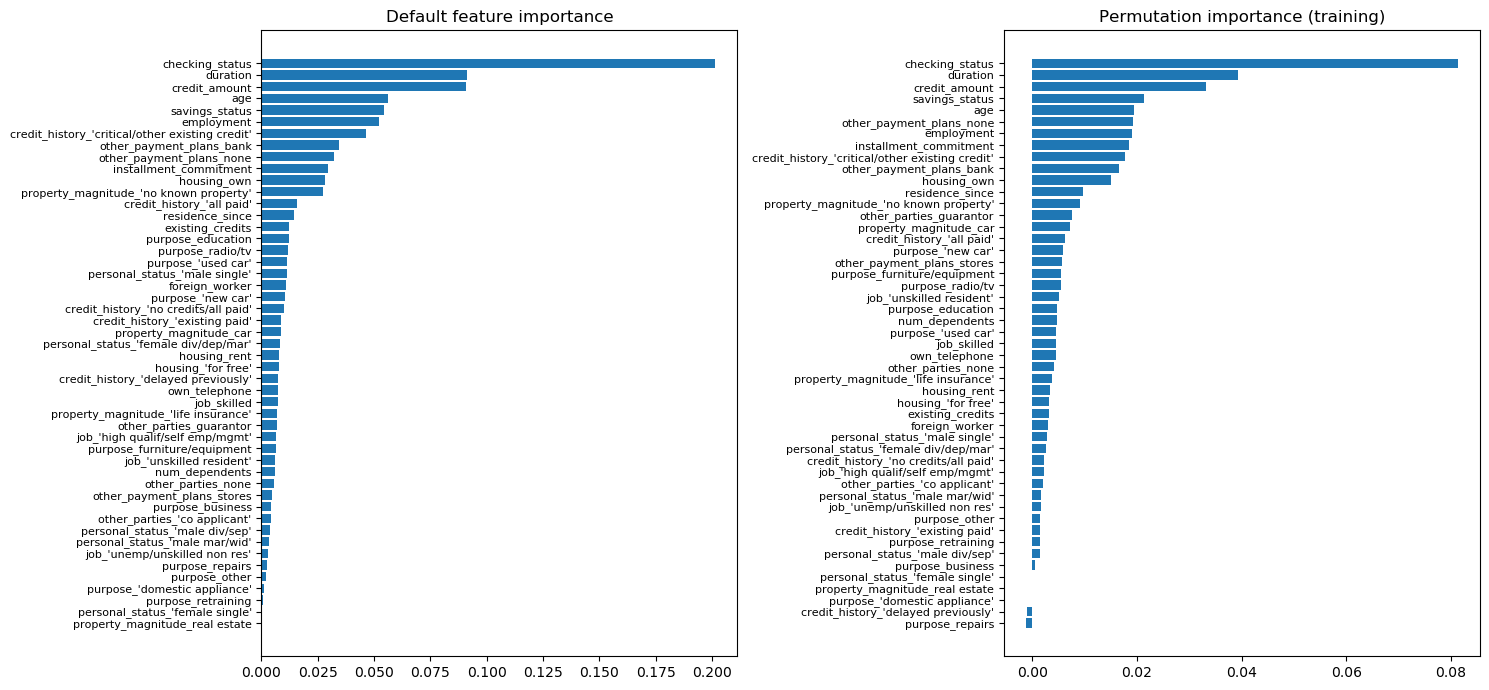

In [27]:
    # Plot the default feature importance and the permutation importance side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    axs[0].set_title('Default feature importance')
    axs[0].barh(range(num_features), random_forest.feature_importances_[feature_indexes])
    axs[0].set_yticks(range(num_features))
    axs[0].set_yticklabels(feature_name_array[feature_indexes], rotation=0, fontsize=8)
    axs[0].invert_yaxis()

    axs[1].set_title('Permutation importance (training)')
    axs[1].barh(range(num_features), permutation_results.importances_mean[permutation_indexes])
    # axs[1].boxplot(permutation_results.importances[permutation_indexes].T, vert=False)
    axs[1].set_yticks(range(num_features))
    axs[1].set_yticklabels(feature_name_array[permutation_indexes], rotation=0, fontsize=8)
    axs[1].invert_yaxis()

    plt.tight_layout()
    plt.show()


### Feature Selection

Check to see if any of the features are uninformative and can be dropped, resulting in a simpler model.

Using ROC AUC as the metric and Recursive Feature Elimiation, which uses the default internal feature importance, 
it turns out that it is optimal to use almost the full set of features anyway.

Optimal number of features : 47
Uninformative features:
["personal_status_'female single'" 'property_magnitude_real estate']


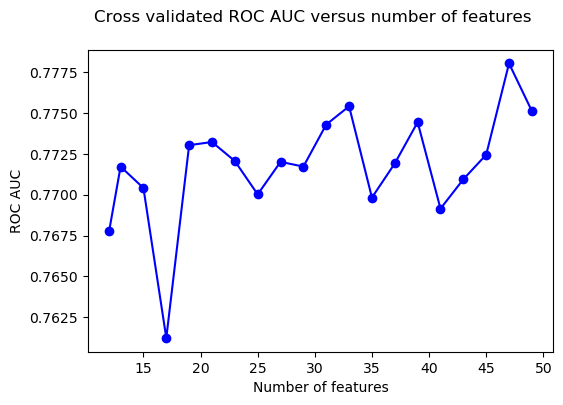

In [64]:
# Use Recursive Feature Elimination with cross validation
from sklearn.feature_selection import RFECV

min_features = 12
step_size = 2
rfecv = RFECV(estimator=random_forest, step=step_size, cv=5,
              scoring='roc_auc', #'accuracy', 
              min_features_to_select=min_features)
rfecv.fit(x_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Uninformative features:")
print(feature_name_array[rfecv.ranking_ != 1])

# Plot number of features VS. cross-validation scores
plt.figure()
plt.suptitle('Cross validated ROC AUC versus number of features')
plt.xlabel("Number of features")
plt.ylabel("ROC AUC")
feature_counts = list(range(num_features - step_size * (len(rfecv.grid_scores_) - 1), num_features + 1, step_size))
if feature_counts[0] < min_features:
    feature_counts[0] = min_features
plt.plot(feature_counts, rfecv.grid_scores_, 'bo-')
plt.show()

### Threshold selection

The Random Forest classifier can provide an estimate of the probability that an example will be of the positive class.
Therefore, we can select a threshold value for the probability that improves the recall of the classifier.

To do this, we use cross validation with a custom scoring function that returns the threshold corresponding to the target recall.
We then plot the ROC curve for the test data set, annotated with the threshold found by cross validation and the actual threshold for the test set. These are quite close.


Threshold for target recall: 0.4496702024879652  std: 0.017230494243057604


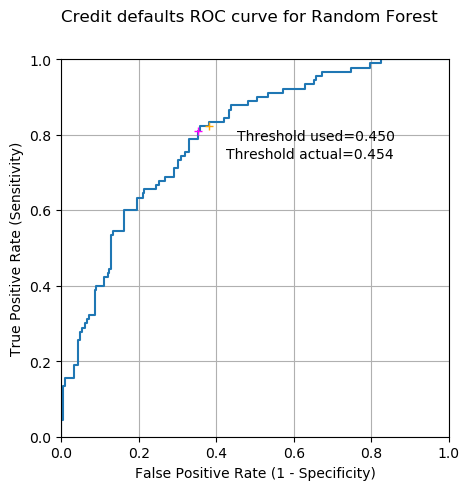

In [7]:
    # Determine the threshold for the target recall using cross validation on the training data
    cv_results = cross_val_score(random_forest, x_train, y_train, cv=5, scoring=RecallThreshold(TARGET_RECALL))
    target_threshold = np.mean(cv_results)
    print('Threshold for target recall:', target_threshold, ' std:', np.std(cv_results))

    # ROC Curve on the test data
    y_test_probs = random_forest.predict_proba(x_test)[:, 1]
    fprs, tprs, thresholds = roc_curve(y_test, y_test_probs)
    plt.figure(figsize=(5, 5))
    plt.suptitle('Credit defaults ROC curve for Random Forest')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.plot(fprs, tprs)
    # Plot the threshold obtained above using cross validation
    tpr = tprs[thresholds <= target_threshold][0]
    fpr = fprs[thresholds <= target_threshold][0]
    plt.plot(fpr, tpr, '+', color='orange')
    plt.annotate('Threshold used={:5.3f}'.format(target_threshold), xy=(fpr, tpr), xytext=(20, -10), textcoords='offset points')

    # Get the threshold where the recall (TPR) actually meets or exceeds the target recall
    t2 = thresholds[tprs >= TARGET_RECALL][0]
    tpr = tprs[thresholds <= t2][0]
    fpr = fprs[thresholds <= t2][0]
    plt.plot(fpr, tpr, '+', color='magenta')
    plt.annotate('Threshold actual={:5.3f}'.format(t2), xy=(fpr, tpr), xytext=(20, -20), textcoords='offset points')
    plt.show()


### Compare the performance

We can compare the performance of the classifier with the threshold versus the default using the confusion matrix.

The recall for positive class (bad loans) is now over 80% with a reduction in the recall of the negative class but only a small reduction in the precision of the of the positive class and overall accuracy.

In [8]:
    # Use the default threshold (0.5) on the test data
    y_test_pred = random_forest.predict(x_test)
    cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    print('Test confusion matrix with default threshold (0.5)')
    print(cm_test)
    cr_test = classification_report(y_test, y_test_pred, labels=range(len(classes)), target_names=classes)
    print(cr_test)

    # Use the threshold for the target recall obtained using cross validation above on the test data
    y_test_probs = random_forest.predict_proba(x_test)[:, 1]
    y_test_pred = (y_test_probs >= target_threshold).astype(np.int32)
    cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    print('Test confusion matrix with threshold = {:5.3f}'.format(target_threshold))
    print(cm_test)
    cr_test = classification_report(y_test, y_test_pred, labels=range(len(classes)), target_names=classes)
    print(cr_test)


Test confusion matrix with default threshold (0.5)
[[154  56]
 [ 29  61]]
              precision    recall  f1-score   support

        good       0.84      0.73      0.78       210
         bad       0.52      0.68      0.59        90

    accuracy                           0.72       300
   macro avg       0.68      0.71      0.69       300
weighted avg       0.75      0.72      0.73       300

Test confusion matrix with threshold = 0.450
[[134  76]
 [ 16  74]]
              precision    recall  f1-score   support

        good       0.89      0.64      0.74       210
         bad       0.49      0.82      0.62        90

    accuracy                           0.69       300
   macro avg       0.69      0.73      0.68       300
weighted avg       0.77      0.69      0.71       300



### Accuracy versus threshold

We can visualise how the accuracy varies with threshold and show the confusion matrix for the threshold that gives the maximum accuracy.

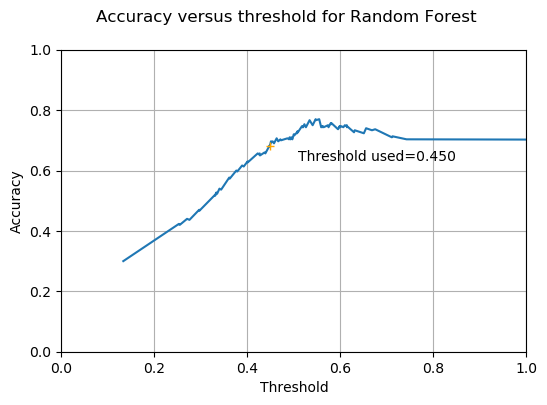

Test confusion matrix for max accuracy with threshold = 0.554
[[183  27]
 [ 42  48]]
              precision    recall  f1-score   support

        good       0.81      0.87      0.84       210
         bad       0.64      0.53      0.58        90

    accuracy                           0.77       300
   macro avg       0.73      0.70      0.71       300
weighted avg       0.76      0.77      0.76       300



In [9]:
    # Compute accuracy per threshold
    p = np.sum(y_test)
    n = y_test.size - p
    tps = tprs * p
    fps = fprs * n
    tns = n - fps
    accuracies = (tps + tns) / y_test.size
    plt.suptitle('Accuracy versus threshold for Random Forest')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.plot(thresholds, accuracies)
    # Plot the threshold obtained above using cross validation
    t3 = thresholds[thresholds <= target_threshold][0]
    acc = accuracies[thresholds <= target_threshold][0]
    plt.plot(t3, acc, '+', color='orange')
    plt.annotate('Threshold used={:5.3f}'.format(target_threshold), xy=(t3, acc), xytext=(20, -10), textcoords='offset points')
    plt.show()

    # Use the threshold that gives the highest accuracy
    ta = thresholds[np.argmax(accuracies)]
    y_test_pred = (y_test_probs >= ta).astype(np.int32)
    cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    print('Test confusion matrix for max accuracy with threshold = {:5.3f}'.format(ta))
    print(cm_test)
    cr_test = classification_report(y_test, y_test_pred, labels=range(len(classes)), target_names=classes)
    print(cr_test)

### Cost sensitive threshold

We now use the cost matrix provided to determine a threshold that minimises the cost.

The cost matrix is formulated here following the Sckit-learn confusion matrix convention with the positive class corresponding to bad loans, and so does not correspond directly with the cost matrix as formulated in Elkan. Additionally, Elkan argues that since the action in the case of predicting a bad loan is not to make the loan, the cost of mis-classifying a good loan as bad is zero but the benefit of correctly classifying a good loan is 1. See Elkan for more details.

The threshold is computed using cross validation with a custom scoring function that returns the threshold corresponding to the minimum cost. The cost curve is computed using a Python function.


Minimum Cost threshold=0.349, std=0.042
Optimal Cost threshold=0.422, min cost=-63.000


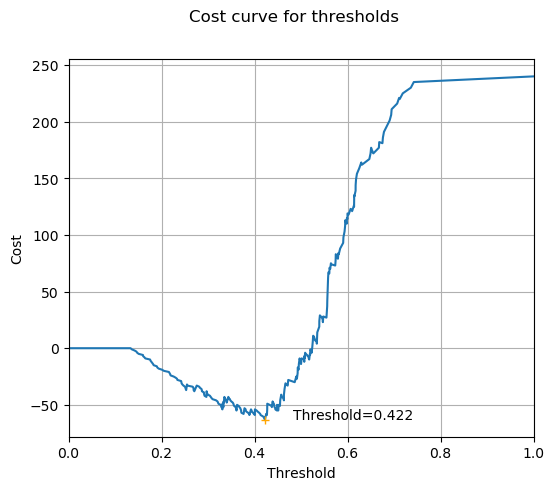

In [10]:
    # Compute the cost curve using a cost matrix following the Scikit-learn confusion matrix convention
    # and where the positive class is 'Bad'.
    # [Cost of TN, Cost of FP]
    # [Cost of FN, Cost of TP]
    from Costs import cost_curve, expected_cost
    from Scoring import CostThreshold
    from Plots import plot_calibration_curve, plot_cost_curve

    # Interestingly, both formulations of the cost matrix give the same curve and threshold.
    # cost_matrix = np.array([[0.0, 1.0],
    #                         [5.0, 0.0]])
    cost_matrix = np.array([[-1.0, 0.0],
                            [5.0, 0.0]])

    # Determine the threshold for the minimum cost using cross validation on the training data
    cv_results = cross_val_score(random_forest, x_train, y_train, cv=5, scoring=CostThreshold(cost_matrix))
    cost_threshold = np.mean(cv_results)
    print("Minimum Cost threshold={:5.3f}, std={:5.3f}".format(cost_threshold, np.std(cv_results)))

    # Compare with the Minimum Cost threshold on the test data
    costs, thresholds = cost_curve(y_test, y_test_probs, cost_matrix)

    print("Optimal Cost threshold={:5.3f}, min cost={:6.3f}".format(thresholds[np.argmin(costs)], np.min(costs)))

    # Cost Curve
    plt.figure(figsize=(6, 5))
    plt.suptitle('Cost curve for thresholds')
    plot_cost_curve(costs, thresholds)
    plt.show()


### Probability Calibration

If we wanted to use the probabilities directly and not just to select a threshold, then more accurate probabilities are needed.
We can visualise the calibration of the probabilities using a reliability curve.

Scikit-learn provides a Calibrated classifier that fits the probability curve to be closer to the ideal line. This can be fitted using cross validation on the training data.

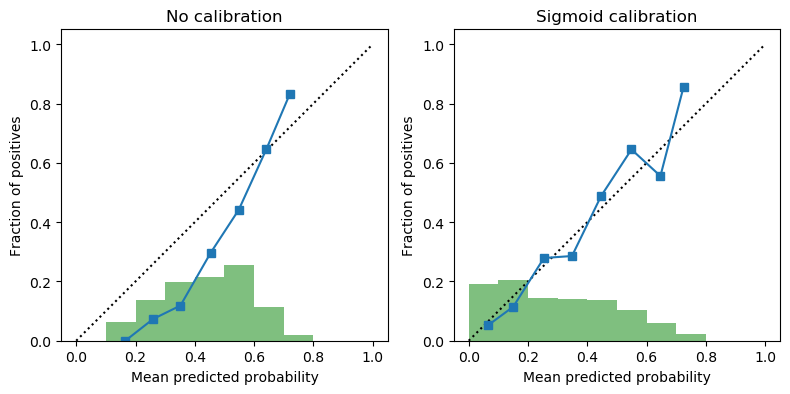

In [11]:
    # So far we have estimated the optimal threshold.
    # If we want to compute an expected value, for example the expected cost, then we need more accurate probabilities.
    # Calibration can be done using cross validation or a validation set - but not the training or test data.
    from sklearn.calibration import CalibratedClassifierCV

    # Calibrate the random forest model using a sigmoid since the number of training examples is relatively small.
    random_forest_calibrated = CalibratedClassifierCV(random_forest, cv=5, method='sigmoid')
    random_forest_calibrated.fit(x_train, y_train)

    # Check the probability calibration by plotting the predicted versus the observed probabilities.
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    y_val_probs = random_forest.predict_proba(x_test)[:, 1]
    axes[0].set_title('No calibration')
    plot_calibration_curve(y_test, y_val_probs, ax=axes[0])

    y_val_calibrated_probs = random_forest_calibrated.predict_proba(x_test)[:, 1]
    axes[1].set_title('Sigmoid calibration')
    plot_calibration_curve(y_test, y_val_calibrated_probs, ax=axes[1])

    plt.tight_layout()
    plt.show()


### Calibrated Probabilities

Now that we have calibrated probabilities, we can compare the minimum cost threshold with the theoretical threshold given in Elkan equation 2. The threshold is now closer to the theoretical value.

We can also use the probabilities to calculate expected values.

Theoretical calibrated threshold=0.167
Optimal calibrated threshold=0.244, min cost=-67.00
Expected cost= 92.32


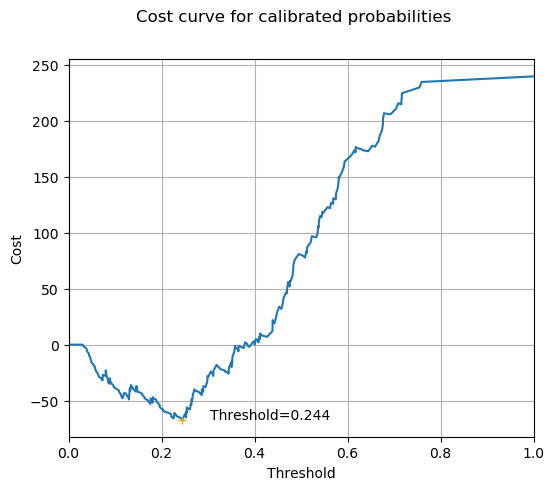

In [12]:
    # Calculate the theoretical threshold for the cost matrix using Elkan equation 2,
    # but reformulated for the Scikit-learn confusion matrix convention
    # and where the positive class is 'Bad'.
    theoretical_cost_threshold = (cost_matrix[0,1] - cost_matrix[0,0]) / (cost_matrix[0,1] - cost_matrix[0,0] +
                                                                          cost_matrix[1,0] - cost_matrix[1,1])
    print("Theoretical calibrated threshold={:5.3f}".format(theoretical_cost_threshold))

    # Calculate the Minimum Cost threshold on the test data using the calibrated probabilities
    y_test_calibrated_probs = random_forest_calibrated.predict_proba(x_test)[:, 1]
    costs, thresholds = cost_curve(y_test, y_test_calibrated_probs, cost_matrix)

    print("Optimal calibrated threshold={:5.3f}, min cost={:6.2f}".format(thresholds[np.argmin(costs)], np.min(costs)))

    # Calculate the Expected value of the Costs
    exp_cost = expected_cost(y_test, y_test_calibrated_probs, cost_matrix)
    print("Expected cost={:6.2f}".format(exp_cost))

    # Cost Curve
    plt.figure(figsize=(6, 5))
    plt.suptitle('Cost curve for calibrated probabilities')
    plot_cost_curve(costs, thresholds)
    plt.show()
